# import the libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
###################################
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"
######################################
from sklearn.preprocessing import OneHotEncoder,QuantileTransformer,RobustScaler,StandardScaler,MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer,TransformedTargetRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn import set_config
#############################################################################
from scipy.stats import norm
###############################
import warnings
warnings.filterwarnings('ignore')

# data overview

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/amankharwal/Website-data/master/advertising.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [4]:
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


In [5]:
df.shape

(200, 4)

# explory data analysis

In [6]:
#unique values in each column
dict_={}
for feature in df.columns:
    dict_[feature]=((df[feature].value_counts().shape[0]))
pd.DataFrame(dict_,index=['unique_counts']).transpose()

,unique_counts
TV,190
Radio,167
Newspaper,172
Sales,121


In [7]:
df.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,15.130500
std,85.854236,14.846809,21.778621,5.283892
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,11.000000
50%,149.750000,22.900000,25.750000,16.000000
75%,218.825000,36.525000,45.100000,19.050000
max,296.400000,49.600000,114.000000,27.000000


In [8]:
# percentage of missing values in each category
dict_={}
for feature in df.columns:
    dict_[feature]=((df[feature].isnull().sum())/len(df))*100
pd.DataFrame(dict_,index=['%age of missing value']).transpose()

,%age of missing value
TV,0.0
Radio,0.0
Newspaper,0.0
Sales,0.0


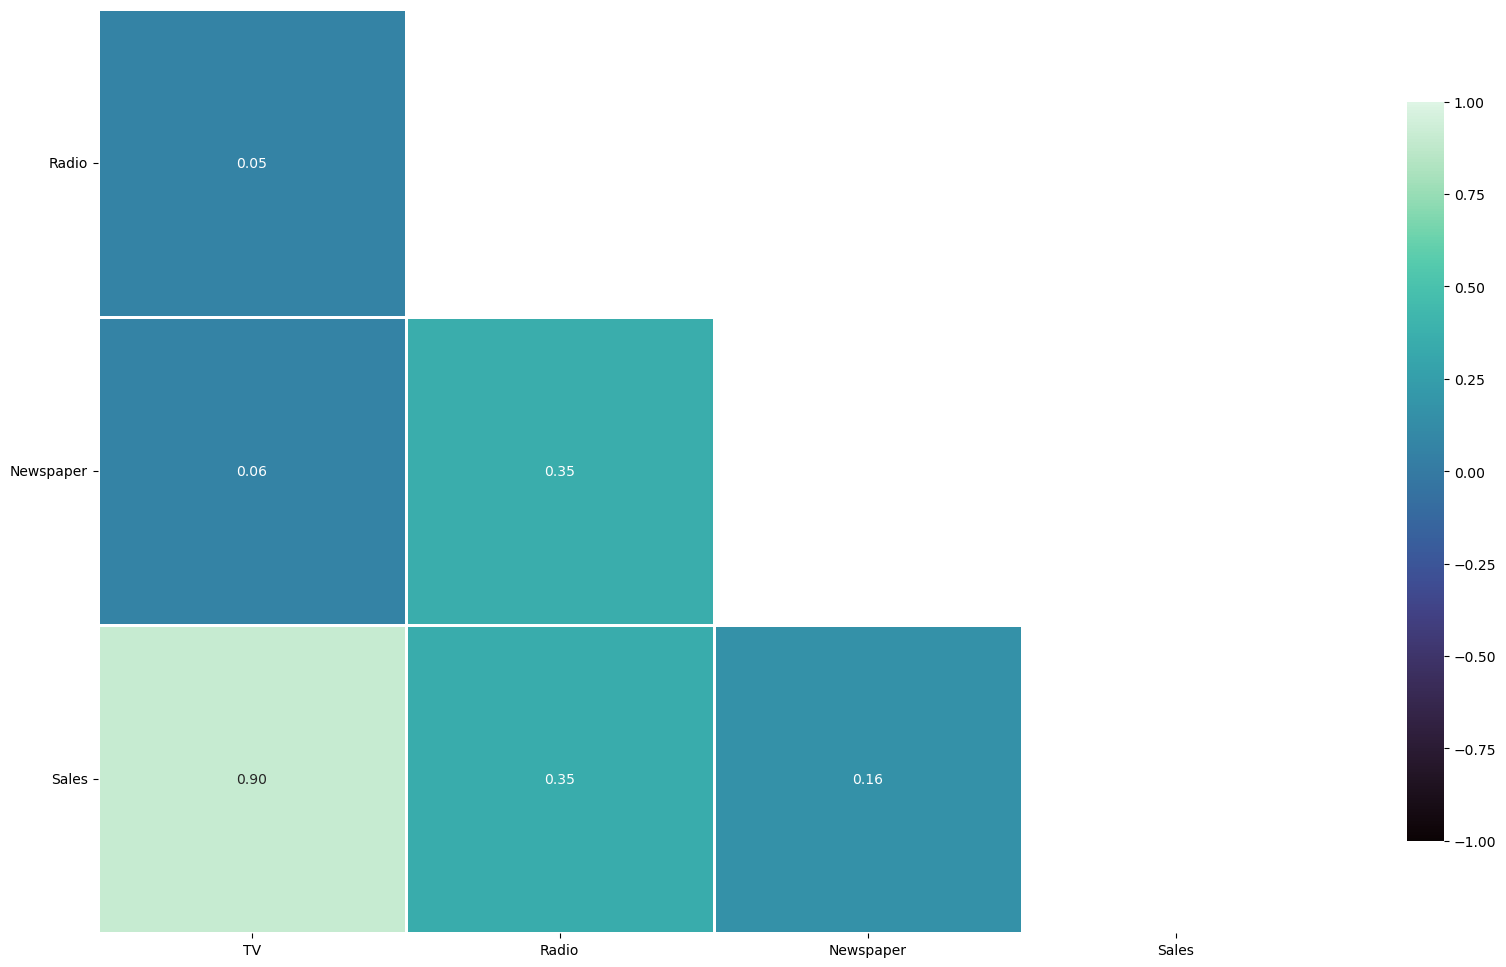

In [9]:
plt.figure(figsize=(20, 12))

dfCorr= df.corr()


mask = np.triu(np.ones_like(dfCorr, dtype=np.bool))
mask = mask[1:, :]


sns.heatmap(data=dfCorr.iloc[1:,:], vmin=-1, vmax=1, cbar_kws={"shrink": .8},annot=True, mask=mask,
            cmap='mako' ,square=True, linewidths=1, fmt=".2f")

plt.yticks(rotation=0)
plt.show()

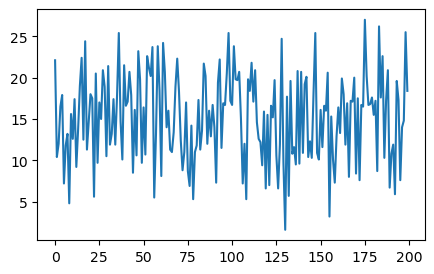

In [10]:
plt.figure(figsize=(5, 3))
df['Sales'].plot()
plt.show()

<Axes: xlabel='TV', ylabel='Sales'>

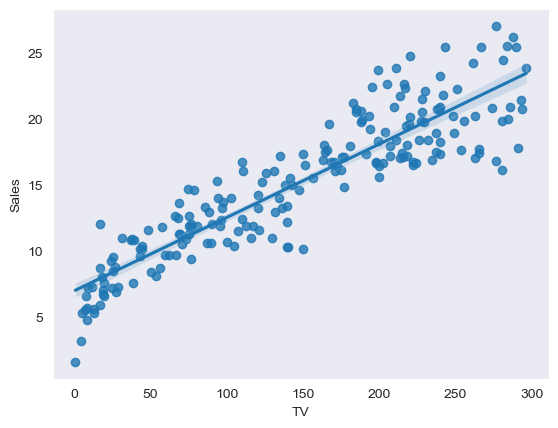

In [11]:
# Closing price vs the Volume
sns.set_style("dark")
sns.regplot(df,x='TV',y='Sales')

<Axes: xlabel='Radio', ylabel='Sales'>

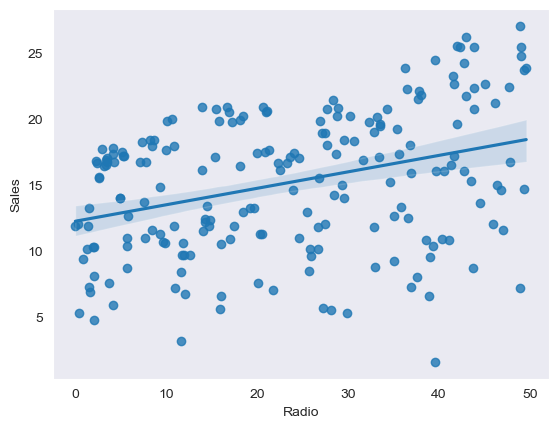

In [12]:
# Closing price vs the Volume
sns.set_style("dark")
sns.regplot(df,x='Radio',y='Sales')

<Axes: xlabel='Newspaper', ylabel='Sales'>

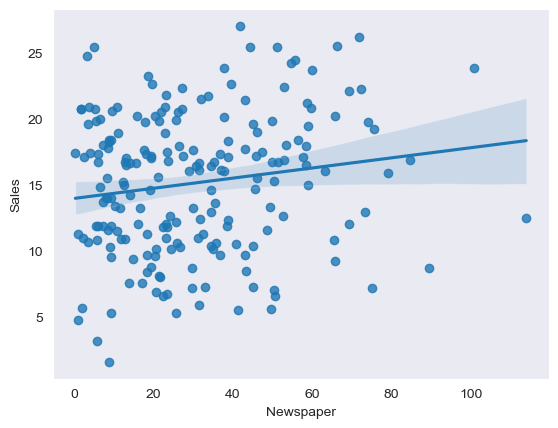

In [13]:
# Closing price vs the Volume
sns.set_style("dark")
sns.regplot(df,x='Newspaper',y='Sales')

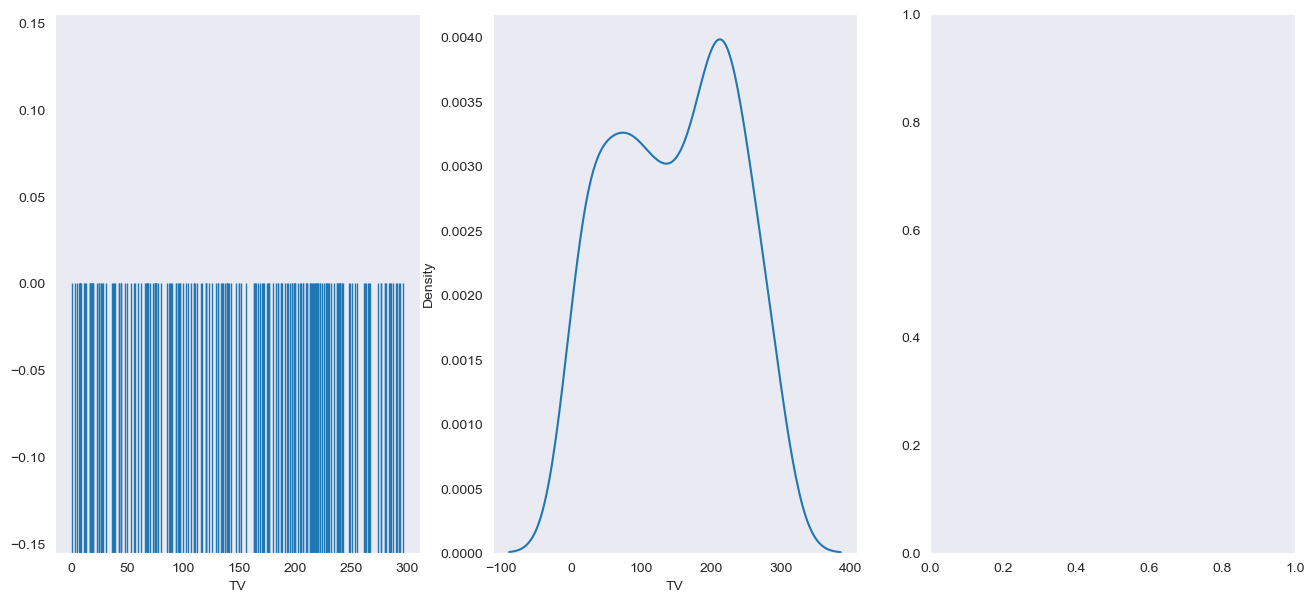

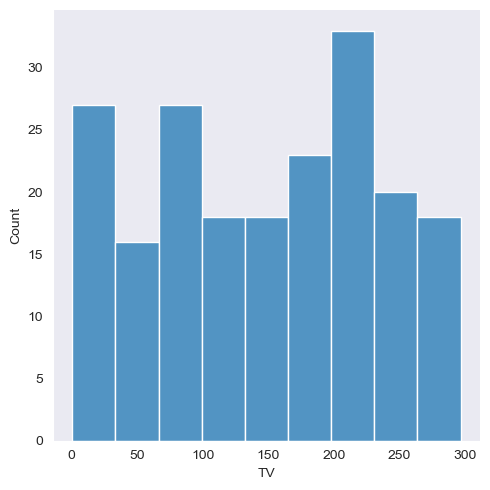

In [14]:
fig , axes = plt.subplots(1,3,figsize=(16,7))
sns.rugplot(ax = axes[0], data=df, x="TV", height=0.5)
sns.kdeplot(ax = axes[1], data=df, x="TV")
sns.displot(ax = axes[2], data=df, x="TV")

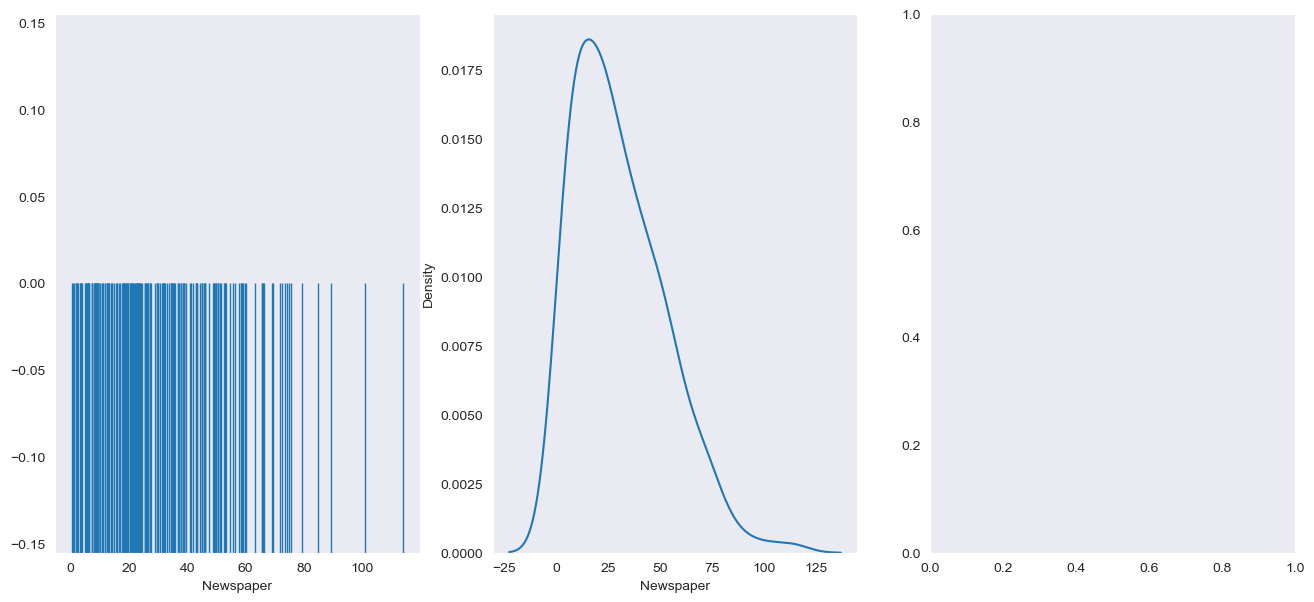

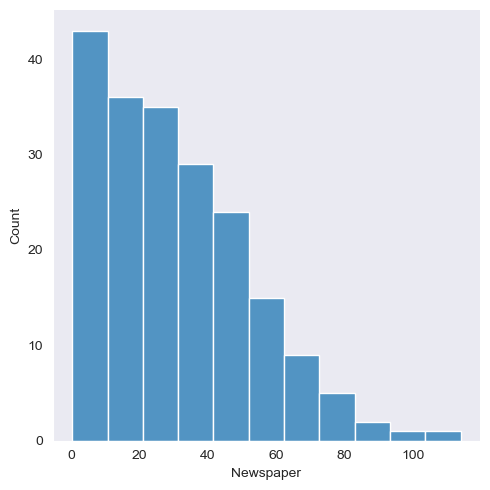

In [15]:
fig , axes = plt.subplots(1,3,figsize=(16,7))
sns.rugplot(ax = axes[0], data=df, x="Newspaper", height=0.5)
sns.kdeplot(ax = axes[1], data=df, x="Newspaper")
sns.displot(ax = axes[2], data=df, x="Newspaper")

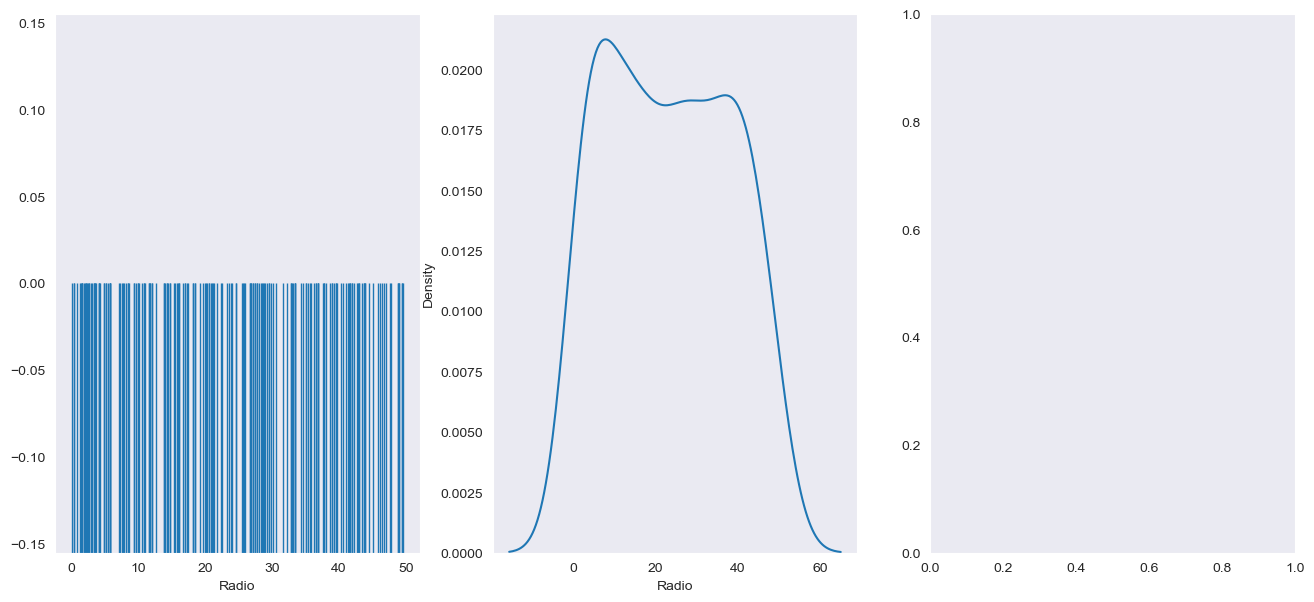

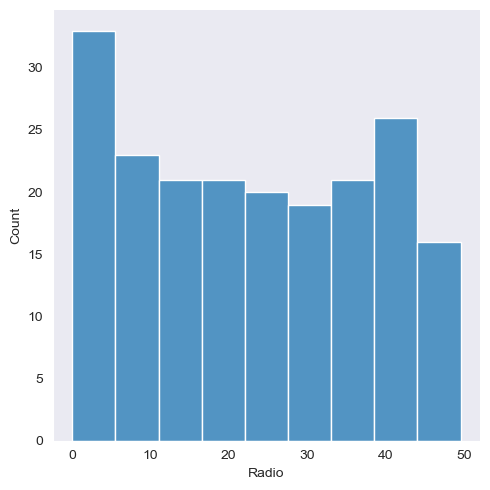

In [16]:
fig , axes = plt.subplots(1,3,figsize=(16,7))
sns.rugplot(ax = axes[0], data=df, x="Radio", height=0.5)
sns.kdeplot(ax = axes[1], data=df, x="Radio")
sns.displot(ax = axes[2], data=df, x="Radio")

<Axes: xlabel='Sales'>

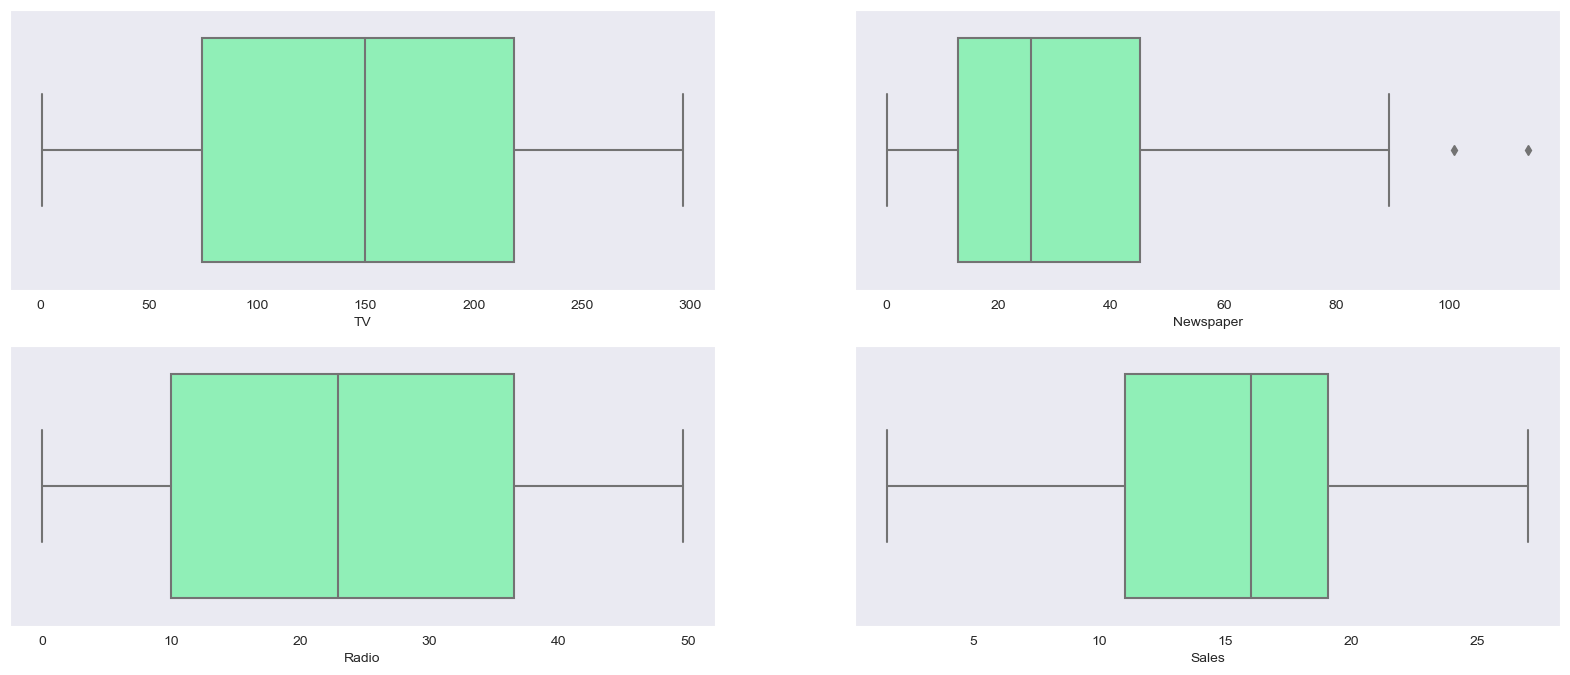

In [17]:
#Analysis of the numerical features 
fig=plt.figure(figsize=(20,8))
ax=[None for _ in range(4)]
ax[0]=plt.subplot2grid((2,2),(0,0))
ax[1]=plt.subplot2grid((2,2),(0,1))
ax[2]=plt.subplot2grid((2,2),(1,0))
ax[3]=plt.subplot2grid((2,2),(1,1))

sns.boxplot(x='TV',data=df,palette='rainbow',ax=ax[0])
sns.boxplot(x='Newspaper',data=df,palette='rainbow',ax=ax[1])
sns.boxplot(x='Radio',data=df,palette='rainbow',ax=ax[2])
sns.boxplot(x='Sales',data=df,palette='rainbow',ax=ax[3])



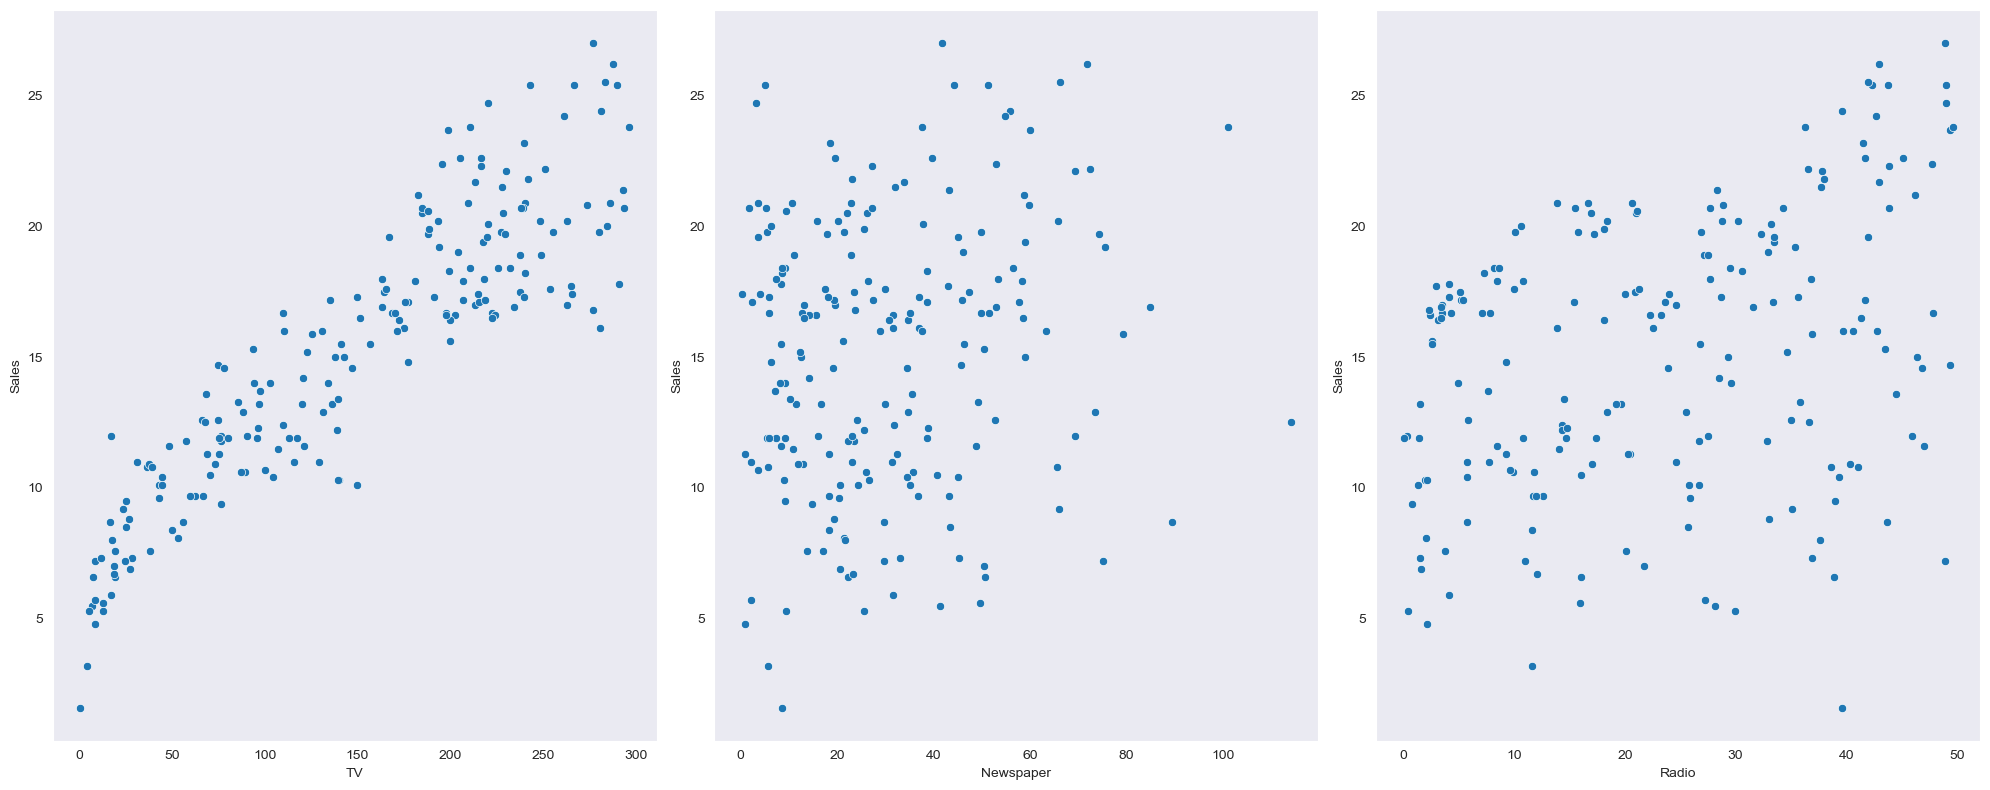

In [18]:
#bivariate analysis: to see how the other features are correlated with delivery time 'Sales'
fig=plt.figure(figsize=(20,8))
ax=[None for _ in range(3)]
ax[0]=plt.subplot2grid((1,3),(0,0))
ax[1]=plt.subplot2grid((1,3),(0,1))
ax[2]=plt.subplot2grid((1,3),(0,2))

sns.scatterplot(x='TV',y='Sales',data=df,ax=ax[0])
sns.scatterplot(x='Newspaper',y='Sales',data=df,ax=ax[1])
sns.scatterplot(x='Radio',y='Sales',data=df,ax=ax[2])
plt.tight_layout()

# daealing with outliers

**Newspaper Outliers**

In [19]:
def find_outliers_IQR(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    
    iqr = q3 - q1
    
    outliers = df[((df<(q1-1.5*iqr))| (df>(q3 + 1.5*iqr)))]
    return outliers


outliers = find_outliers_IQR(df['Newspaper'])
print ('number of outliers'+str(len(outliers)))
print ('max outliers value'+str(outliers.max()))
print ('min outliers value'+str(outliers.min()))


df["Newspaper"].describe()

number of outliers2
max outliers value114.0
min outliers value100.9


count    200.000000
mean      30.554000
std       21.778621
min        0.300000
25%       12.750000
50%       25.750000
75%       45.100000
max      114.000000
Name: Newspaper, dtype: float64

In [20]:
df.drop(index=outliers.index,inplace=True)

outliers = find_outliers_IQR(df['Newspaper'])
print ('number of outliers'+str(len(outliers)))
print ('max outliers value'+str(outliers.max()))
print ('min outliers value'+str(outliers.min()))

df["Newspaper"].describe()

number of outliers0
max outliers valuenan
min outliers valuenan


count    198.000000
mean      29.777273
std       20.446303
min        0.300000
25%       12.650000
50%       25.600000
75%       44.050000
max       89.400000
Name: Newspaper, dtype: float64

# 📈 Training a Simple Linear Regression Model

# Data Prepration

### Differences between MinMaxScaler and StandardScaler

Both MinMaxScaler and StandardScaler scale the data, but they use different methods to achieve this. MinMaxScaler scales the data to a fixed range, typically between 0 and 1. On the other hand, StandardScaler rescales the data to have a mean of 0 and a standard deviation of 1. This results in a distribution with zero mean and unit variance. The choice between MinMaxScaler and StandardScaler depends on the data distribution, the nature of the analysis, and the algorithm being used.

**What is Normalization?**

Normalization refers to the rescaling of the features to a range of [0, 1], which is a special case of min-max scaling. To normalize the data, the min-max scaling can be applied to one or more feature columns.

**What is Standardization?**

The standardization technique is used to center the feature columns at mean 0 with a standard deviation of 1 so that the feature columns have the same parameters as a standard normal distribution. Unlike Normalization, standardization maintains useful information about outliers and makes the algorithm less sensitive to them in contrast to min-max scaling, which scales the data to a limited range of values.

In [21]:
#MinMaxScaler is a class from sklearn.preprocessing which is used for normalization.

from sklearn.preprocessing import MinMaxScaler

# define min max scaler
scaler = MinMaxScaler()
# transform data
scaled = scaler.fit_transform(df)

In [22]:
print(scaled)

[[0.78320246 0.76209677 0.77328844 0.80708661]
 [0.14953909 0.79233871 0.50280584 0.34645669]
 [0.05633322 0.92540323 0.77441077 0.40944882]
 [0.51485149 0.83266129 0.65319865 0.58661417]
 [0.61488563 0.21774194 0.65207632 0.64173228]
 [0.02731308 0.9858871  0.83838384 0.22047244]
 [0.19392284 0.66129032 0.26038159 0.4015748 ]
 [0.40798907 0.39516129 0.12682379 0.45669291]
 [0.02697166 0.04233871 0.00785634 0.12598425]
 [0.67975418 0.05241935 0.2345679  0.5511811 ]
 [0.2232844  0.11693548 0.26823793 0.43307087]
 [0.73062479 0.48387097 0.04152637 0.62204724]
 [0.07886651 0.70766129 0.7362514  0.2992126 ]
 [0.33048822 0.15322581 0.07744108 0.47637795]
 [0.69443496 0.66330645 0.51290685 0.68503937]
 [0.66473199 0.96169355 0.59034792 0.81889764]
 [0.95834756 0.7983871  0.62289562 0.8976378 ]
 [0.23386821 0.41330645 0.2020202  0.38188976]
 [0.50051212 0.48185484 0.21099888 0.51181102]
 [0.74325708 0.55846774 0.5959596  0.64566929]
 [0.80812564 0.10282258 0.26038159 0.62598425]
 [0.04267668 

# Seperating Target variables and features

In [23]:
# Target Variable
y = df["Sales"]

# Features
X = df.drop(["Sales"],axis=1)

In [24]:
from sklearn.model_selection import train_test_split

X_Train,X_Test,y_Train,y_Test = train_test_split(X,y,test_size=0.2, random_state=101)

# LinearRegression Model

In [25]:
from sklearn.linear_model import LinearRegression

# Making the model using LinearRegression()
model = LinearRegression()

# Fiting the training data in the model
model.fit(X_Train,y_Train)

LinearRegression()

# Predicting the model

In [26]:
y_pred=model.predict(X_Test)

In [27]:
y_pred[:5]

array([16.97599602, 18.98924895, 25.12270969, 13.05595549,  7.94542544])

# Coeficient Matrix (Find the coefficients)

In [28]:
model.coef_

array([ 0.05577057,  0.10535877, -0.00210076])

In [29]:
pd.DataFrame(model.coef_, X.columns, columns=['coef'] )

,coef
TV,0.055771
Radio,0.105359
Newspaper,-0.002101


# Evalutaing the Model (Find the error (MSE) of the model)

In [30]:
from sklearn import metrics

In [31]:
MAE = metrics.mean_absolute_error(y_Test, y_pred)
MSE = metrics.mean_squared_error(y_Test, y_pred)
RMSE = np.sqrt(MSE)

In [32]:
pd.DataFrame([MAE, MSE, RMSE], index=['MAE', 'MSE', 'RMSE'], columns=['Metrics'])

,Metrics
MAE,1.617372
MSE,4.411631
RMSE,2.100388


In [33]:
MAE

1.6173719693291653

In [34]:
MSE

4.411631038101562

In [35]:
RMSE

2.1003883065046716

# Residuals (Difference between y_test and y_pred)

In [36]:
test_residuals=y_Test-y_pred

In [37]:
test_residuals[:5]

162    2.924004
141    0.210751
175    1.877290
157   -2.955955
132   -2.245425
Name: Sales, dtype: float64

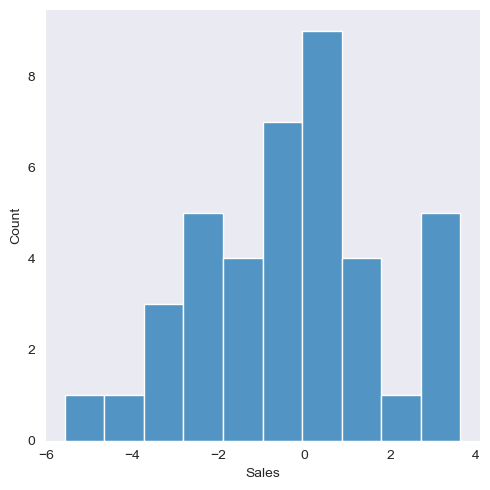

In [38]:
sns.displot(test_residuals, bins=10)

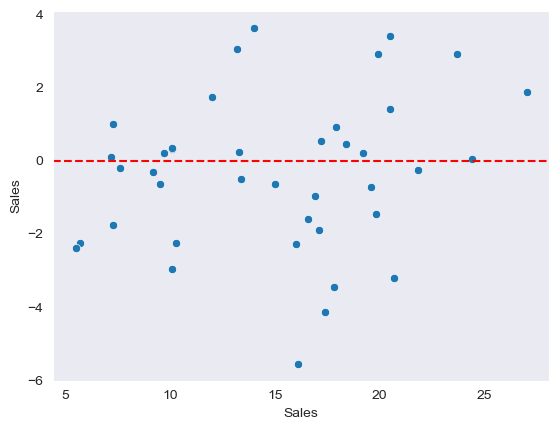

In [39]:
sns.scatterplot(x=y_Test, y=test_residuals)
plt.axhline(y=0, color='r', ls='--')

# R2 Score

In [40]:
from sklearn.metrics import r2_score
score =r2_score(y_Test, y_pred)
print("The accuracy of our model is {}%".format(score))

The accuracy of our model is 0.8529474702199036%


In [41]:
#making function
def check (Dimension,testsize):
    r2=0.8529474702199036
    for column in X:
        New_Col_Name=column+str(Dimension)
        New_Col_Val=X[column]**Dimension
        X.insert(0,New_Col_Name,New_Col_Val)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testsize, random_state = 101)
        Newmodel=LinearRegression()
        Newmodel = Newmodel.fit(X_train,y_train)
        y_pred=Newmodel.predict(X_test)
        r2_new=metrics.r2_score(y_test,y_pred)
        if r2_new<r2:
            X.drop([New_Col_Name],axis=1,inplace=True)
        else:
            r2=r2_new
    print("R2 Score : ",r2)
        
check(2,0.2)      

R2 Score :  0.8883825011519999


# 📈 Training a Polynomial Linear Regression Model

# Preprocessing

In [55]:
from sklearn.preprocessing import PolynomialFeatures

In [56]:
polynomial_converter = PolynomialFeatures(degree=2, include_bias=False)

In [57]:
polynomial_features = polynomial_converter.fit_transform(X)

In [58]:
polynomial_features.shape

(198, 20)

# Train the Model

In [59]:
poly_model = LinearRegression()

In [60]:
poly_model.fit(X_Train, y_Train)

LinearRegression()

# Predicting Test Data

In [61]:
y_pred = poly_model.predict(X_Test)

In [62]:
pd.DataFrame({'Y_Test': y_Test,'Y_Pred':y_pred, 'Residuals':(y_Test-y_pred) }).head(5)

,Y_Test,Y_Pred,Residuals
162,19.9,16.975996,2.924004
141,19.2,18.989249,0.210751
175,27.0,25.122710,1.877290
157,10.1,13.055955,-2.955955
132,5.7,7.945425,-2.245425


# Evaluating the Model

In [63]:
from sklearn import metrics

In [64]:
MAE_poly = metrics.mean_absolute_error(y_Test, y_pred)
MSE_poly = metrics.mean_squared_error(y_Test, y_pred)
RMSE_poly = np.sqrt(MSE_poly)

pd.DataFrame([MAE_poly, MSE_poly, RMSE_poly], index=['MAE', 'MSE', 'RMSE'], columns=['Metrics'])

,Metrics
MAE,1.617372
MSE,4.411631
RMSE,2.100388


In [65]:
# Train List of RMSE per degree
train_RMSE_list = []
# Test List of RMSE per degree
test_RMSE_list = []

for d in range(1,10):
    
    # Preprocessing
    # Create poly data set for degree (d)
    polynomial_converter = PolynomialFeatures(degree=d, include_bias=False)
    polynomial_features = polynomial_converter.fit(X)
    polynomial_features = polynomial_converter.transform(X)
    
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(polynomial_features, y, test_size=0.3, random_state=101)
    
    # Train the Model
    poly_model = LinearRegression()
    poly_model.fit(X_train, y_train)
    
    # Predicting on both Train & Test Data
    y_train_pred = poly_model.predict(X_train)
    y_test_pred = poly_model.predict(X_test)
    
    # RMSE of Train set
    train_RMSE = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    
    # RMSE of Test Set
    test_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
    
    # Append the RMSE to the Train and Test List
    train_RMSE_list.append(train_RMSE)
    test_RMSE_list.append(test_RMSE)

In [66]:
train_RMSE_list

[1.3583095568043784,
 1.1215377235531754,
 1.0935240917837843,
 3.6041052672835705,
 1.0802502542530583,
 1.2158469151127285,
 1.7093770775909147,
 1.8473361892234865,
 2.1738584840937203]

# Plot the Polynomial degree VS RMSE

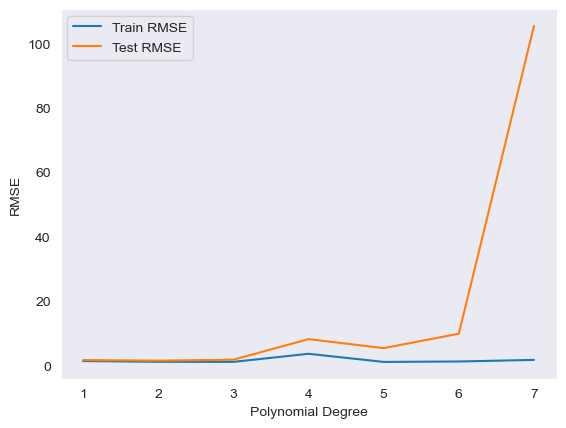

In [69]:
plt.plot(range(1,8), train_RMSE_list[:7], label='Train RMSE')
plt.plot(range(1,8), test_RMSE_list[:7], label='Test RMSE')

plt.xlabel('Polynomial Degree')
plt.ylabel('RMSE')
plt.legend()

**Best wish to uou ;)**

***ArmaN***